# Figure Eight: Medical Sentence Summary

## https://www.kaggle.com/kmader/figure-eight-medical-sentence-summary

*I didn't find a dataset that mer all of the requirements on archive.ics so I picked one from Kaggle

### 1. Loading the dataset

In [1]:
rdd = sc.textFile('train.csv')
header = rdd.first()
print len(header.split(',')), 'columns'
rdd = rdd.filter(lambda line: line != header)

23 columns


### 2. Transforming the data to RDD pairs

In [2]:
from csv import reader
pairs = rdd.map(lambda x: (x.split(',')[0], 
                           list(reader([x.encode('utf-8')], delimiter=',', quotechar='"')
                               ))).map(lambda x: (x[0], x[1][0][1:]))
print pairs.count(), 'rows'

13340 rows


In [3]:
pairs.first()

(u'1',
 ['502808352',
  '7/13/14 13:48',
  'clixsense',
  '0.9167',
  '27871219',
  'NLD',
  '7',
  'Amsterdam',
  '87.210.207.223',
  'IM CEFTRIAXONE treats URETHRAL OR RECTAL GONORRHEA',
  '41',
  '128',
  '',
  '69',
  '142',
  'treats',
  '1',
  '907845-FS1-2',
  'For treatment of uncomplicated cervical, URETHRAL OR RECTAL GONORRHEA CDC and others recommend IM ceftriaxone or oral cefixime; IM CEFTRIAXONE is drug of choice for pharyngeal infections.',
  'URETHRAL OR RECTAL GONORRHEA',
  'IM CEFTRIAXONE',
  'RO-may_treat'])

### 3.a Counting distinct values

In [4]:
print 'Channel', pairs.map(lambda x: (x[1][2])).countApproxDistinct(), 'distinct values'
print 'Trust', pairs.map(lambda x: (x[1][3])).countApproxDistinct(), 'distinct values'
print 'Country', pairs.map(lambda x: (x[1][5])).countApproxDistinct(), 'distinct values'
print 'City', pairs.map(lambda x: (x[1][7])).countApproxDistinct(), 'distinct values'
print 'Relation', pairs.map(lambda x: (x[1][15])).countApproxDistinct(), 'distinct values'

Channel 39 distinct values
Trust 881 distinct values
Country 5 distinct values
City 420 distinct values
Relation 9 distinct values


### 3.b Distributions

In [5]:
import matplotlib
import matplotlib.pyplot as plt

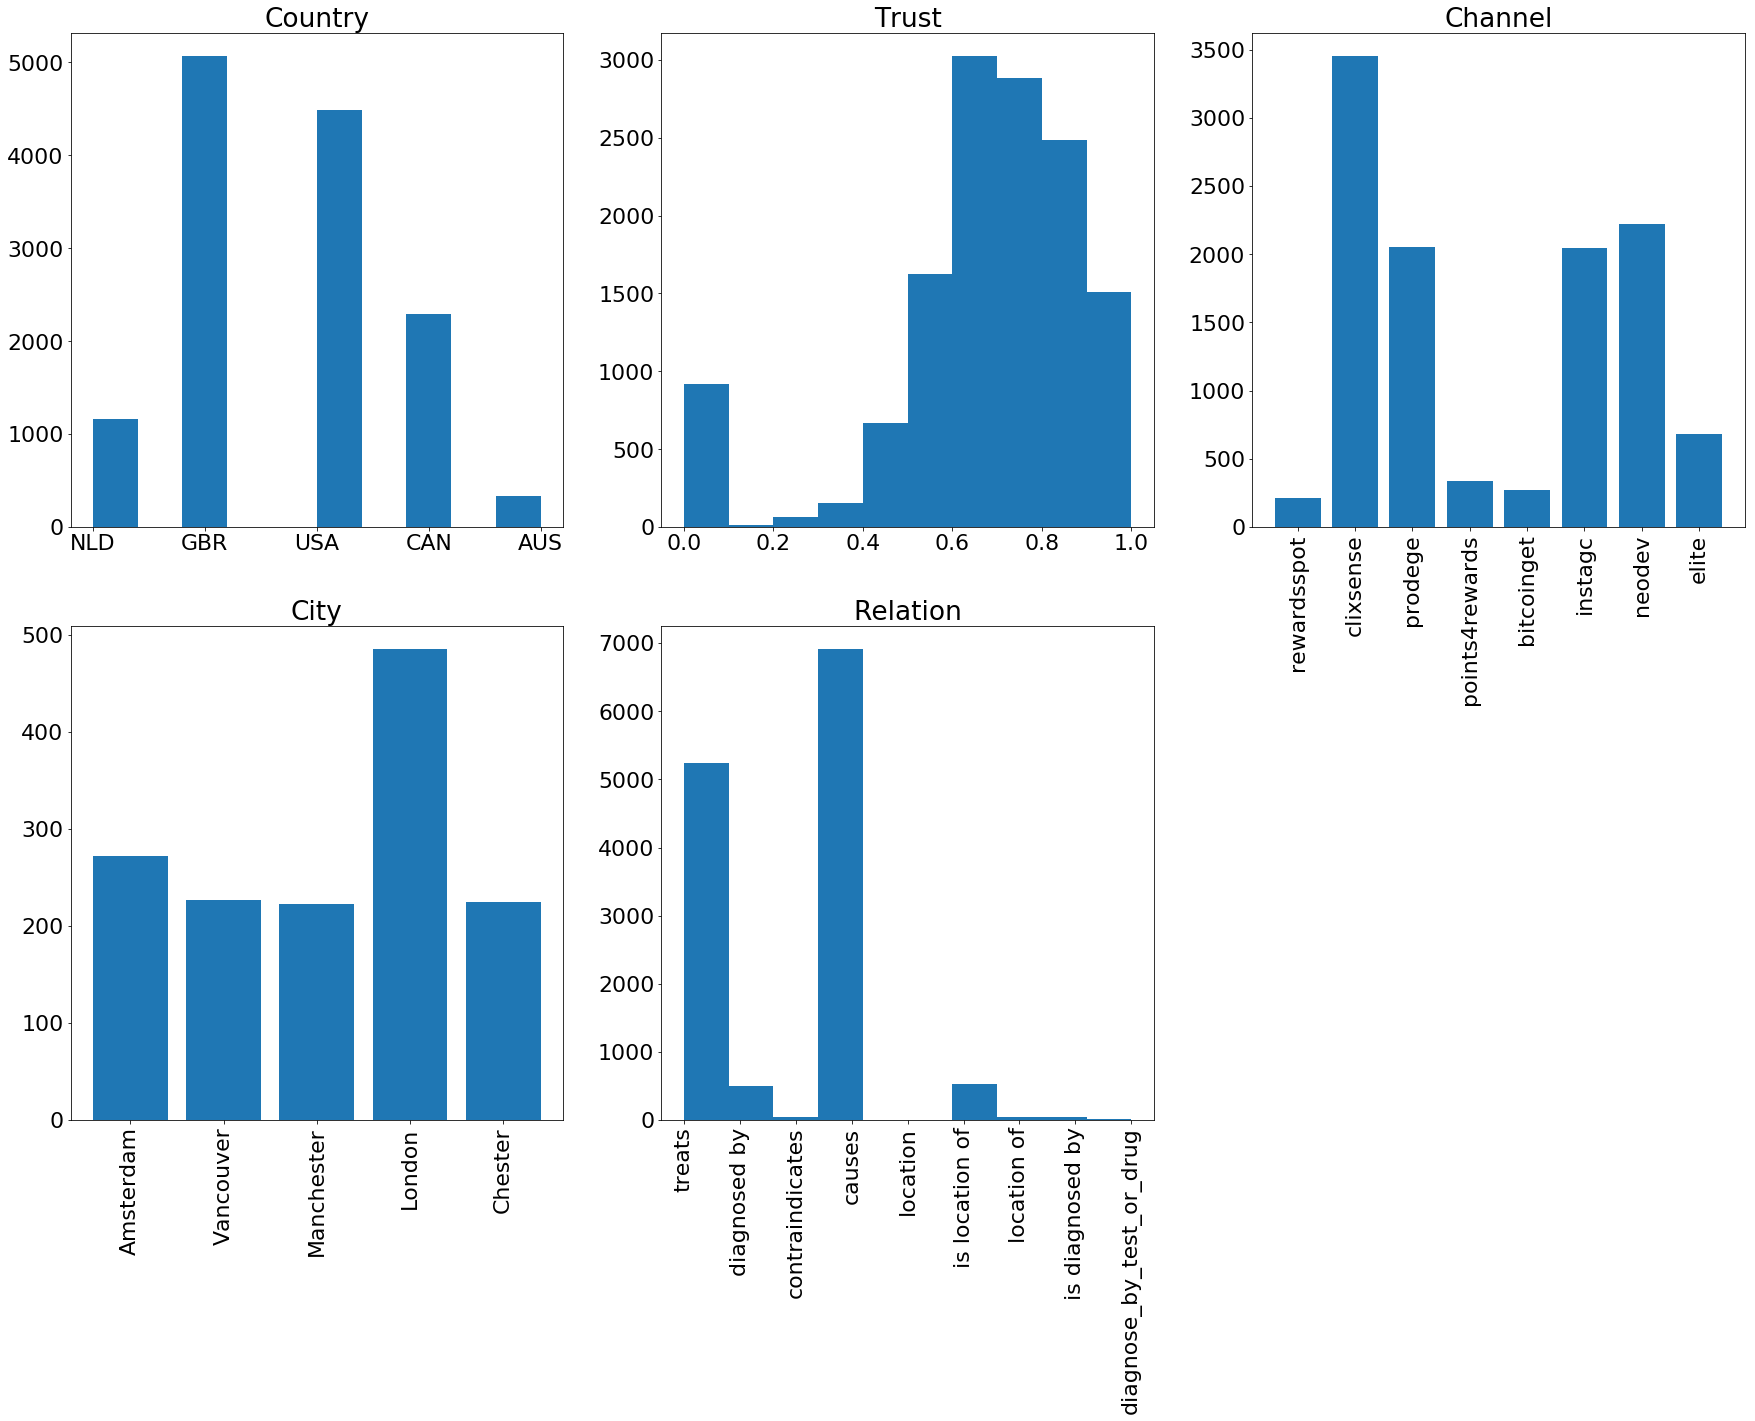

In [6]:
matplotlib.rcParams.update({'font.size': 22})

ax = plt.subplot(2,3,1)
ax.set_title('Country')
ax.hist(pairs.map(lambda x: (x[1][5])).collect())

ax = plt.subplot(2,3,2)
ax.set_title('Trust')
ax.hist(pairs.map(lambda x: float((x[1][3]))).collect())

ax = plt.subplot(2,3,3)
ax.set_title('Channel')
filtered = { k: v for k,v in pairs.map(lambda x: (x[1][2])).countByValue().iteritems() 
            if k <> '' and v > 200 }
ax.bar(filtered.keys(), filtered.values())
plt.xticks(rotation=90)
ax.figure.set_size_inches(30, 20)

ax = plt.subplot(2,3,4)
ax.set_title('City')
filtered = { k: v for k,v in pairs.map(lambda x: (x[1][7])).countByValue().iteritems() 
            if k <> '' and v > 200 }
ax.bar(filtered.keys(), filtered.values())
plt.xticks(rotation=90)

ax = plt.subplot(2,3,5)
ax.set_title('Relation')
ax.hist(pairs.map(lambda x: (x[1][15])).collect())
plt.xticks(rotation=90)

plt.show() 

### 3.c Explaining the results

It's easy to see that UK is the most popular country in the dataset and London is the most seen city. The relations field in the show that "causes" and "treats" are the most common relations and that trust with the doctor is on average between 0.6 and 0.8.

### 4. Filling in missing values

There were no missing or bad numerical values in the dataset, but if there were missing values I would find the mean value of the column and insert it in the missing places like so - 

pairs = pairs.map(lambda x: (x[0], x[1]) if x[1][3] else (x[0], x[1][:2] + [pairs.map(lambda x: float(x[1][3])).mean()] + x[1][4:]))

### 5. Transforming categorical to numerical features

In [7]:
from sklearn import preprocessing

# transform 'country'
le = preprocessing.LabelEncoder()
le.fit(pairs.map(lambda x: (x[1][5])).collect())
pairs = pairs.map(lambda x: (x[0], x[1] + [unicode(le.transform([x[1][5]])[0])]))

# transform 'relation'
le2 = preprocessing.LabelEncoder()
le2.fit(pairs.map(lambda x: (x[1][15])).collect())
pairs = pairs.map(lambda x: (x[0], x[1] + [unicode(le2.transform([x[1][15]])[0])]))

pairs.first()

(u'1',
 ['502808352',
  '7/13/14 13:48',
  'clixsense',
  '0.9167',
  '27871219',
  'NLD',
  '7',
  'Amsterdam',
  '87.210.207.223',
  'IM CEFTRIAXONE treats URETHRAL OR RECTAL GONORRHEA',
  '41',
  '128',
  '',
  '69',
  '142',
  'treats',
  '1',
  '907845-FS1-2',
  'For treatment of uncomplicated cervical, URETHRAL OR RECTAL GONORRHEA CDC and others recommend IM ceftriaxone or oral cefixime; IM CEFTRIAXONE is drug of choice for pharyngeal infections.',
  'URETHRAL OR RECTAL GONORRHEA',
  'IM CEFTRIAXONE',
  'RO-may_treat',
  u'3',
  u'8'])

### 6. Transforming timestamp to categorical features

In [8]:
# add hour
pairs = pairs.map(lambda x: (x[0], x[1] + [x[1][1].split(' ')[1]]))
# add day
pairs = pairs.map(lambda x: (x[0], x[1] + [x[1][1].split('/')[1]]))
# add month
pairs = pairs.map(lambda x: (x[0], x[1] + [x[1][1].split('/')[0]]))

pairs.first()

(u'1',
 ['502808352',
  '7/13/14 13:48',
  'clixsense',
  '0.9167',
  '27871219',
  'NLD',
  '7',
  'Amsterdam',
  '87.210.207.223',
  'IM CEFTRIAXONE treats URETHRAL OR RECTAL GONORRHEA',
  '41',
  '128',
  '',
  '69',
  '142',
  'treats',
  '1',
  '907845-FS1-2',
  'For treatment of uncomplicated cervical, URETHRAL OR RECTAL GONORRHEA CDC and others recommend IM ceftriaxone or oral cefixime; IM CEFTRIAXONE is drug of choice for pharyngeal infections.',
  'URETHRAL OR RECTAL GONORRHEA',
  'IM CEFTRIAXONE',
  'RO-may_treat',
  u'3',
  u'8',
  '13:48',
  '13',
  '7'])

### 7. Normalizing numerical columns

In [9]:
from pyspark.mllib.feature import Normalizer

# normalizing 'trust'
normalizer = Normalizer()
key_normalized_pairs = sc.parallelize(zip(pairs.map(lambda x: x[0]).collect(), 
                                          normalizer.transform(pairs.map(lambda x: x[1][3]).
                                                               collect())))
pairs = pairs.join(key_normalized_pairs).map(lambda x: (x[0], x[1][0] + [x[1][1]]))

pairs.first()

(u'10611',
 ['788748042',
  '9/15/15 18:33',
  'instagc',
  '0.8861',
  '31184650',
  'USA',
  'IA',
  'Mason City',
  '173.26.179.94',
  'EYE DROPS treats ALLERGIC CONJUNCTIVITIS',
  '27',
  '3',
  '',
  '50',
  '12',
  'treats',
  '0.997054486',
  '221971',
  'as [EYE DROPS] , Crolom) for [ALLERGIC CONJUNCTIVITIS].',
  'ALLERGIC CONJUNCTIVITIS',
  'EYE DROPS',
  'TWrex-treat',
  u'4',
  u'8',
  '18:33',
  '15',
  '9',
  0.010800293941057578])

### 8. Transforming text features

#### 8.a Tokenizing

In [10]:
from pyspark.ml.feature import Tokenizer

# tokenizing 'sentence'
tokenizer = Tokenizer(inputCol='_2', outputCol='words')
key_tokenized_pairs = tokenizer.transform(pairs.map(lambda x: (x[0], x[1][18]))
                                          .toDF()).select('_1', 'words').rdd.map(list)
pairs = pairs.join(key_tokenized_pairs).map(lambda x: (x[0], x[1][0] + [x[1][1]]))

pairs.first()

(u'3922',
 ['503729702',
  '7/16/14 22:26',
  'clixsense',
  '0.6636',
  '19803139',
  'NLD',
  '6',
  'Veldhoven',
  '212.61.84.196',
  'CONVENTIONAL INTENSITY WARFARIN THERAPY treats RECURRENT VENOUS THROMBOEMBOLISM',
  '118',
  '50',
  '',
  '149',
  '89',
  'treats',
  '0.99503719',
  '907299-FS1-2',
  'Comparison of low intensity warfarin therapy with CONVENTIONAL INTENSITY WARFARIN THERAPY for long term prevention of RECURRENT VENOUS THROMBOEMBOLISM',
  'RECURRENT VENOUS THROMBOEMBOLISM',
  'CONVENTIONAL INTENSITY WARFARIN THERAPY',
  'RO-may_prevent',
  u'3',
  u'8',
  '22:26',
  '16',
  '7',
  0.008088336597772043,
  [u'comparison',
   u'of',
   u'low',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'with',
   u'conventional',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'for',
   u'long',
   u'term',
   u'prevention',
   u'of',
   u'recurrent',
   u'venous',
   u'thromboembolism']])

#### 8.b Removing stop words

In [11]:
from pyspark.ml.feature import StopWordsRemover

# removing stop words from 'sentence'
stop_words_remover = StopWordsRemover(inputCol='_2', outputCol='filtered')
key_filtered_pairs = stop_words_remover.transform(pairs.map(lambda x: (x[0], x[1][28]))
                                                  .toDF()).select('_1', 'filtered').rdd.map(list)
pairs = pairs.join(key_filtered_pairs).map(lambda x: (x[0], x[1][0] + [x[1][1]]))

pairs.first()

(u'3922',
 ['503729702',
  '7/16/14 22:26',
  'clixsense',
  '0.6636',
  '19803139',
  'NLD',
  '6',
  'Veldhoven',
  '212.61.84.196',
  'CONVENTIONAL INTENSITY WARFARIN THERAPY treats RECURRENT VENOUS THROMBOEMBOLISM',
  '118',
  '50',
  '',
  '149',
  '89',
  'treats',
  '0.99503719',
  '907299-FS1-2',
  'Comparison of low intensity warfarin therapy with CONVENTIONAL INTENSITY WARFARIN THERAPY for long term prevention of RECURRENT VENOUS THROMBOEMBOLISM',
  'RECURRENT VENOUS THROMBOEMBOLISM',
  'CONVENTIONAL INTENSITY WARFARIN THERAPY',
  'RO-may_prevent',
  u'3',
  u'8',
  '22:26',
  '16',
  '7',
  0.008088336597772043,
  [u'comparison',
   u'of',
   u'low',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'with',
   u'conventional',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'for',
   u'long',
   u'term',
   u'prevention',
   u'of',
   u'recurrent',
   u'venous',
   u'thromboembolism'],
  [u'comparison',
   u'low',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'co

#### 8.c Vectorizing to binary

In [12]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# vectorizing 'sentence'
enc = OneHotEncoder()
enc.fit(np.array(pairs.map(lambda x: (x[1][18])).collect()).reshape(-1, 1))
pairs = pairs.map(lambda x: (x[0], x[1] + [enc.transform(np.array(x[1][18])
                                                         .reshape(-1, 1)).toarray().tolist()]))

pairs.first()

(u'3922',
 ['503729702',
  '7/16/14 22:26',
  'clixsense',
  '0.6636',
  '19803139',
  'NLD',
  '6',
  'Veldhoven',
  '212.61.84.196',
  'CONVENTIONAL INTENSITY WARFARIN THERAPY treats RECURRENT VENOUS THROMBOEMBOLISM',
  '118',
  '50',
  '',
  '149',
  '89',
  'treats',
  '0.99503719',
  '907299-FS1-2',
  'Comparison of low intensity warfarin therapy with CONVENTIONAL INTENSITY WARFARIN THERAPY for long term prevention of RECURRENT VENOUS THROMBOEMBOLISM',
  'RECURRENT VENOUS THROMBOEMBOLISM',
  'CONVENTIONAL INTENSITY WARFARIN THERAPY',
  'RO-may_prevent',
  u'3',
  u'8',
  '22:26',
  '16',
  '7',
  0.008088336597772043,
  [u'comparison',
   u'of',
   u'low',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'with',
   u'conventional',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'for',
   u'long',
   u'term',
   u'prevention',
   u'of',
   u'recurrent',
   u'venous',
   u'thromboembolism'],
  [u'comparison',
   u'low',
   u'intensity',
   u'warfarin',
   u'therapy',
   u'co